## Is it a bird?

In [57]:
%load_ext autoreload
%autoreload 2
%pdb on

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned ON


In [58]:
from IPython.core.debugger import set_trace
from pathlib import Path
import jupyter_plz
import requests
import socket
import os
from random import shuffle
from IPython.display import Image as IPImage
from urllib.parse import urlparse
from tqdm import tqdm
import hashlib
from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image as PilImage
import urllib.parse

In [59]:
from fastcore.all import *
from fastai.vision.all import *

Let's check if we have internet:

In [60]:
def check_internet_connection():
    try:
        # connect to the host -- tells us if the host is actually reachable
        socket.create_connection(("www.google.com", 80))
        return True
    except OSError:
        pass
    return False

In [61]:
# Verify internet connection
assert check_internet_connection()

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

<div style="text-align:center;margin-top:25px;">
   <img style="width:33%" src="https://imgs.xkcd.com/comics/tasks_2x.png" />
</div>

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

Let's download images of `birds` and `forests`:

In [62]:
from duckduckgo_search import ddg_images
from fastcore.all import *

We create a function that takes a term (`string`) and the number of images:

In [63]:
def search_images(term: str, max_images: int = 200) -> List[str]:
    """Search for image URLs using DuckDuckGo and a search term of interest.
    
    Args:
        term: the search term of interest (example: `forest` or `bird`).
        max_images: the maximum number of images to return.
        
    Returns:
        urls: the raw image urls.
    """
    results = [item["image"] for item in ddg_images(term, max_results=max_images)]
    return shuffle(results) or results

In [64]:
# Get the results
images = search_images("forest", max_images=10)

Let's write a function that validates the image urls:

In [65]:
def verify_image_url(url):
    
    # Splitting the path
    file_name, file_extension = os.path.splitext(urlparse(url).path)
    
    # Checking if the file extension is one of the common image formats
    if file_extension in ['.jpg', '.jpeg', '.png', '.gif', '.bmp']:
        return True
    else:
        return False

Let's filter the images:

In [66]:
valid_images = list(filter(verify_image_url, images))
len(valid_images), len(images)

(10, 10)

Let's start by searching for bird photos and visualizing the results we get.

We'll start by getting the URLs using the function we built:

In [67]:
urls = search_images("bird photos", max_images=1)
urls = list(filter(verify_image_url, urls))
urls[0]

'http://hdqwalls.com/wallpapers/colorful-parrot-bird.jpg'

Let's create a function to download the URLs locally:

In [68]:
def download_images(urls, directory):
    paths = []
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(download_image, url, directory) for url in urls]
        for future in tqdm(as_completed(futures), total=len(futures)):
            file_path = future.result()
            if file_path:
                paths.append(file_path)
    return paths

def download_image(url, directory):
    try:
        response = requests.get(url)
        parsed_url = urllib.parse.urlparse(url)
        filename, ext = os.path.splitext(os.path.basename(parsed_url.path))
        ext = ext.split("?")[0] # remove anything after '?'
        if len(filename) > 250:
            filename = hashlib.sha256(filename.encode()).hexdigest()
        filename += ext
        filepath = os.path.join(directory, filename)
        with open(filepath, 'wb') as f:
            f.write(response.content)
        return filepath
    except requests.exceptions.RequestException as e:
        pass

In [69]:
images = download_images(urls, Path("./data/images/"))

100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


Let's visualize it:

In [71]:
IPImage(url=images[0], width=256, height=256)

Let's do the same with "forest photos":

In [72]:
forest_img = download_images(list(filter(verify_image_url, search_images("forest_photos", max_images=1))), 
                             Path("./data/images/"))
forest_img

100%|██████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


['data/images/65540-nature-forest-river.jpg']

In [74]:
IPImage(url=forest_img[0], width=256, height=256)

Our searches seem to be giving reasonable results.

Let's grab 200 examples of `bird` and 200 examples of `forest` and save each in a separate directory:

In [17]:
# Set the directories
bird_dir = Path("./data/images/birds/")
forest_dir = Path("./data/images/forests/")

# Create the directories
bird_dir.mkdir(exist_ok=True)
forest_dir.mkdir(exist_ok=True)

In [18]:
# Download the bird images
bird_imgs = list(map(Path, download_images(list(filter(verify_image_url, 
                                                       search_images("bird", max_images=200))), 
                                           bird_dir)))

# Download the forest images
forest_imgs = list(map(Path, download_images(list(filter(verify_image_url, 
                                                         search_images("forest", max_images=200))), 
                                             forest_dir)))

# Verify images were downloaded
assert bird_imgs and forest_imgs

100%|██████████████████████████████████████████████████| 183/183 [00:40<00:00,  4.50it/s]


Let's verify the images and remove the bad files:

In [19]:
def verify_image(fn):
    "Confirm that `fn` can be opened"
    try:
        im = PilImage.open(fn)
        im.draft(im.mode, (32,32))
        im.load()
        return False
    except: return True

In [20]:
# Delete bad images
bad_birds = list(filter(verify_image, bird_imgs))
bad_forests = list(filter(verify_image, forest_imgs))
bad_imgs = list(set(bad_birds + bad_forests))
_ = [(fp.exists() and fp.unlink()) for fp in bad_imgs]
len(bad_imgs)

49

Let's resize all images:

In [21]:
# Get the file lists
birds = list(Path("./data/images/birds/").glob("**/*"))
forests = list(Path("./data/images/forests/").glob("**/*"))
len(birds), len(forests)

(165, 158)

In [22]:
def resize_image(file_path, max_size):
    img = PilImage.open(file_path)
    if img.size[0] > max_size or img.size[1] > max_size:
        img.thumbnail((max_size, max_size))
        img.save(file_path)

In [23]:
# Resize all images
_ = list(map(lambda url: resize_image(url, 400), birds))
_ = list(map(lambda url: resize_image(url, 400), forests))

## Step 2: Train our model

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* and a *validation set*.

- *training set*: the images used for model training.
- *validation set*: the images used for model validation (generalizability).

In FastAI, we can create that easily using a `DataBlock`. We can also visualize a single training batch.

In [30]:
# Set the directory that contains the category folders
path = Path("./data/images/")
assert path.exists()

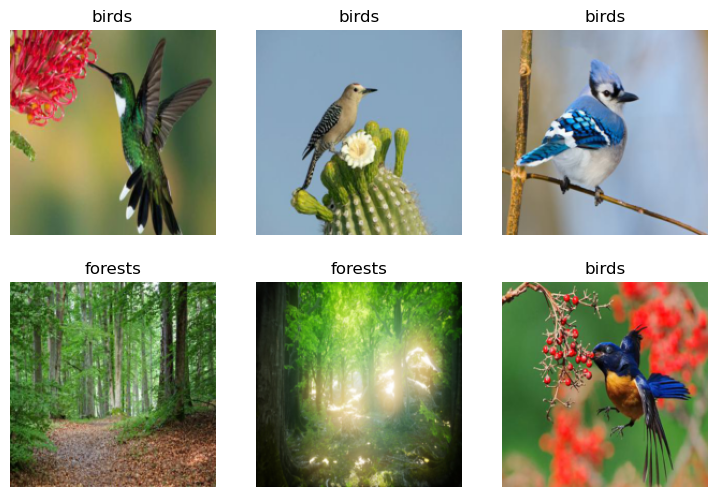

In [32]:
# create the data loaders
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method="squish")]
).dataloaders(path)
dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [37]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/akramz/miniconda3/envs/learn_fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/akramz/miniconda3/envs/learn_fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.882149,0.471691,0.156250,00:07


/Users/akramz/miniconda3/envs/learn_fastai/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.086510,0.051736,0.015625,00:09
1,0.052126,0.002005,0.000000,00:09
2,0.034843,0.000416,0.000000,00:09


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [77]:
is_bird,_,probs = learn.predict(PILImage.create('data/images/colorful-parrot-bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: birds.
Probability it's a bird: 1.0000


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.

---